### You will use:
* the simple simulation Python code from the first couple of weeks
* the correlation matrix in the Excel workbook Expected Returns BL Shrinkage Estimator.xlsx, tab "Layer Covariance Matrix", cells B30:B36 for standard deviations and C30:I36 for correlations
* the expected returns in column 2021* for expected returns in the Northern Trust PDF

How to map the asset classes (please use the Northern Trust labels in your report):
Covariance --> Northern Trust
Large Cap Stocks > Developed market equities
Small Cap Stocks > Emerging market equities
Gov Bond > US Inflation linked
IG Credit Bond > US investment grade
HY Credit Bond > US high yield
Real Estate > Listed real estate
Cash > Cash

Use the cash flows (in and out of the account) already in the Python code.

Assume that your boss asks you to run a simulation with a sensitivity analysis:
* what happens if during the accumulation phase (young, contributing to account) the allocation is 55 stocks / 30 bonds (you decide how to break it down, and always put 5% in real estate) or 85 stocks / 10 bonds? This is a sensitivity analysis on asset allocation
* what happens if the person increases the contributions while young by 10,000 and the withdrawals when old by 20,000? this is a sensitivity analysis on cash flows

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows=400
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
df_data = pd.read_excel("Northern Trust Asset Management Data.xlsx",sheet_name="Data")
df_stats= pd.read_excel("Northern Trust Asset Management Data.xlsx",sheet_name="STD").sort_values("Asset Type").reset_index(
    drop=True)
df_corr= pd.read_excel("Northern Trust Asset Management Data.xlsx",sheet_name="Correlation")
#df_cov= pd.read_excel("Northern Trust Asset Management Data.xlsx",sheet_name="Covariance").sort_values("index").set_index("index")
df_cashflow=pd.read_excel("Northern Trust Asset Management Data.xlsx",sheet_name="Cashflow")

In [3]:
###  Large Cap Stocks > Developed market equities
df_data.loc[(df_data["Asset Class1"]=="Equities")&
       (df_data["Asset Class2"]=="Developed markets") &
       (df_data["Asset Class3"]=="U.S."),"Asset Type"]="Large Cap Stocks"

###  Small Cap Stocks > Emerging market equities
df_data.loc[(df_data["Asset Class1"]=="Equities")&
       (df_data["Asset Class2"]=="Emerg. markets") &
       (df_data["Asset Class3"]=="Emerging markets"),
           "Asset Type"]="Small Cap Stocks"

###  Gov Bond > US Inflation linked 
df_data.loc[(df_data["Asset Class2"]=="USA")&
       (df_data["Asset Class3"]=="Inflation linked"),
       "Asset Type"]="Gov Bond"

###  IG Credit Bond > US investment grade
df_data.loc[(df_data["Asset Class2"]=="USA")&
       (df_data["Asset Class3"]=="Investment grade"),
       "Asset Type"]="IG Credit Bond"


###  HY Credit Bond > US high yield
df_data.loc[(df_data["Asset Class2"]=="USA")&
       (df_data["Asset Class3"]=="High yield"),
                         "Asset Type"]="HY Credit Bond"

### Real Estate > Listed real estate
df_data.loc[(df_data["Asset Class1"]=="Real")&
       (df_data["Asset Class3"]=="Listed real estate"),"Asset Type"]="Real Estate"

### Cash > Cash
df_data.loc[(df_data["Asset Class1"]=="Fixed Income")&
       (df_data["Asset Class2"]=="USA") &
       (df_data["Asset Class3"]=="Cash"),"Asset Type"]="Cash"

df_data.sort_values("Asset Type",inplace=True)

In [4]:
### Filter on the specified assets
df_data=df_data[~df_data["Asset Type"].isnull()]

### Merge the Sandard Deviation of each asset
df_data=pd.merge(df_data,
         df_stats[['Asset Type','SD']],
         left_on="Asset Type",
         right_on="Asset Type",
         how="left")

In [5]:
df_data=pd.merge(df_data.reset_index(),
             df_corr.rename(columns={"index":"Asset Type"}).reset_index().rename(columns={"index":"Order"})[["Asset Type","Order"]],
             left_on="Asset Type",
             right_on="Asset Type",
             how="left").sort_values("Order").drop("index",axis=1)

df_corr=df_corr.set_index("index")

In [6]:
df_data

,Asset Class1,Asset Class2,Asset Class3,Proxy Index,2021,2019,2018,2017,2016,2015,5 Year Actual Return,Asset Type,SD,Order
4,Equities,Developed markets,U.S.,MSCI United States,4.700,5.700,5.800,5.900,4.800,5.600,10.800,Large Cap Stocks,0.089,0
6,Equities,Emerg. markets,Emerging markets,MSCI Emerging Markets,5.400,6.100,8.300,8.400,7.300,7.800,5.500,Small Cap Stocks,0.101,1
1,Fixed Income,USA,Inflation linked,BBG BarCap U.S. TIPS,2.400,2.600,2.900,3.000,2.500,2.500,3.700,Gov Bond,0.053,2
3,Fixed Income,USA,Investment grade,BBG BarCap U.S. Aggregate,2.300,3.000,3.600,3.200,3.000,3.000,4.300,IG Credit Bond,0.059,3
2,Fixed Income,USA,High yield,BBG BarCap U.S. High Yield,5.500,5.000,4.900,4.800,5.300,5.600,4.800,HY Credit Bond,0.066,4
5,Real,Global,Listed real estate,MSCI ACWI IMI Core Real Estate 6,6.300,6.300,6.000,6.100,6.300,6.900,2.700,Real Estate,0.054,5
0,Fixed Income,USA,Cash,3-month U.S. T-bill,0.100,1.100,2.200,1.700,0.500,1.500,1.100,Cash,0.030,6


In [7]:
df_corr

,Large Cap Stocks,Small Cap Stocks,Gov Bond,IG Credit Bond,HY Credit Bond,Real Estate,Cash
index,,,,,,,
Large Cap Stocks,1.000,0.840,0.338,0.586,0.754,0.750,0.100
Small Cap Stocks,0.840,1.000,0.299,0.552,0.794,0.820,0.495
Gov Bond,0.338,0.299,1.000,0.846,0.806,0.765,0.630
IG Credit Bond,0.586,0.552,0.846,1.000,0.830,0.840,0.676
HY Credit Bond,0.754,0.794,0.806,0.830,1.000,0.850,0.691
Real Estate,0.750,0.820,0.765,0.840,0.850,1.000,0.736
Cash,0.100,0.495,0.630,0.676,0.691,0.736,1.000


### replicates covariance from correlation matrix

In [8]:
SD=df_data["SD"].values.reshape(-1,1)
CorrMat= df_corr.values
# Compute the covariance matrix
OuterProduct = np.dot(SD,SD.T)
CovMat=CorrMat*OuterProduct

In [9]:
asset_allocation_young={"Large Cap Stocks":.45,
                       "Small Cap Stocks":.40,
                       "Gov Bond":.05,
                       "IG Credit Bond":.025,
                       "HY Credit Bond":.025,
                       "Real Estate":.050,
                       "Cash":.00}


asset_allocation_old={"Large Cap Stocks":.35,
                       "Small Cap Stocks":.2,
                       "Gov Bond":.1,
                       "IG Credit Bond":.1,
                       "HY Credit Bond":.1,
                       "Real Estate":.05,
                       "Cash":.1}

In [10]:
ExpRet_2021=(df_data[2021]/100).values.reshape(-1,1)
number_of_assets=len(ExpRet_2021)

# Define the remaining life of this person
Total_years=60
Retire_in_years = 30
retierment_period= Total_years - Retire_in_years
Number_of_simulation=1000

In [11]:
def multi_variate_portfolio_return_computer(expected_return,
                                 covariance,
                                 number_of_years,
                                 NumSim,
                                 list_of_asset_allocation):
    import numpy as np
    simulated_multivariate_return = np.random.multivariate_normal(
        expected_return,
        covariance,
        (number_of_years,NumSim))

    simulated_portfoli_return = simulated_multivariate_return @ np.array(list_of_asset_allocation)
    return simulated_portfoli_return

### Generate Returns

In [12]:
portfolio_return_during_younghood = multi_variate_portfolio_return_computer(ExpRet_2021.flatten(),
                                       CovMat,
                                       Retire_in_years,
                                       Number_of_simulation,
                                       list(asset_allocation_young.values()))

portfolio_return_during_oldhood = multi_variate_portfolio_return_computer(ExpRet_2021.flatten(),
                                       CovMat,
                                       retierment_period,
                                       Number_of_simulation,
                                       list(asset_allocation_old.values()))

C:\Users\fbaharkoush\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


### Case 1
initial_contribution=100000

yearly_contribution=10000

yearly_withdraw=-20000



In [13]:
### Case 1
initial_contribution=100000
yearly_contribution=10000
yearly_withdraw=-20000

In [14]:
portfolio_return=np.concatenate((portfolio_return_during_younghood,
                                 portfolio_return_during_oldhood))

In [15]:
### Earch Column Represnet one possible scenarios in 60 years
df_portfolio=pd.DataFrame(portfolio_return)
df_portfolio=pd.merge(df_portfolio.reset_index().rename(columns={"index":"Year"}),
         df_cashflow,
         left_on="Year",
         right_on="Year",
         how="left")
df_portfolio.head()

,Year,0,1,2,3,4,5,6,7,8,...,992,993,994,995,996,997,998,999,Contribution,Withdraw
0,0,0.167,0.196,0.118,0.167,0.194,-0.082,0.038,0.001,0.082,...,0.180,0.156,-0.018,0.018,-0.151,0.039,0.006,0.017,initial,0
1,1,0.070,-0.049,-0.056,0.026,0.072,0.049,-0.051,0.214,0.112,...,-0.064,0.039,0.082,-0.033,-0.023,-0.060,0.079,-0.010,1,0
2,2,-0.047,0.201,0.106,0.036,-0.102,-0.045,0.110,0.015,0.002,...,0.089,-0.001,0.138,-0.084,0.083,0.049,0.109,0.082,1,0
3,3,0.066,0.163,0.103,0.225,0.008,0.002,-0.037,-0.086,-0.023,...,0.002,0.007,0.056,0.115,0.183,0.104,0.068,-0.059,1,0
4,4,-0.014,-0.016,0.024,0.077,0.132,-0.006,0.079,0.017,0.078,...,0.104,0.079,0.055,-0.075,0.083,0.109,-0.005,0.088,1,0


In [16]:
df_portfolio.loc[df_portfolio["Contribution"]=="initial",
                "Contribution"]=initial_contribution

df_portfolio.loc[df_portfolio["Contribution"]==1,
                "Contribution"]=yearly_contribution



df_portfolio.loc[df_portfolio["Withdraw"]==1,
                "Withdraw"]=yearly_withdraw

In [17]:
df_portfolio.head()

,Year,0,1,2,3,4,5,6,7,8,...,992,993,994,995,996,997,998,999,Contribution,Withdraw
0,0,0.167,0.196,0.118,0.167,0.194,-0.082,0.038,0.001,0.082,...,0.180,0.156,-0.018,0.018,-0.151,0.039,0.006,0.017,100000,0
1,1,0.070,-0.049,-0.056,0.026,0.072,0.049,-0.051,0.214,0.112,...,-0.064,0.039,0.082,-0.033,-0.023,-0.060,0.079,-0.010,10000,0
2,2,-0.047,0.201,0.106,0.036,-0.102,-0.045,0.110,0.015,0.002,...,0.089,-0.001,0.138,-0.084,0.083,0.049,0.109,0.082,10000,0
3,3,0.066,0.163,0.103,0.225,0.008,0.002,-0.037,-0.086,-0.023,...,0.002,0.007,0.056,0.115,0.183,0.104,0.068,-0.059,10000,0
4,4,-0.014,-0.016,0.024,0.077,0.132,-0.006,0.079,0.017,0.078,...,0.104,0.079,0.055,-0.075,0.083,0.109,-0.005,0.088,10000,0


In [18]:
list_of_simulation_df_values=[]
for simulation in list(df_portfolio.drop(["Year","Contribution","Withdraw"],axis=1).columns):
    df_portfolio["Value"] = df_portfolio["Contribution"]*(1+df_portfolio[simulation])
    for i in range(1,len(df_portfolio)):
        df_portfolio.loc[i,"Value"] = ((df_portfolio.loc[i-1,"Value"] * (1+df_portfolio.loc[i,simulation])) +
                                       ((df_portfolio.loc[i,"Contribution"]) * (1+df_portfolio.loc[i,simulation]))+
                                       df_portfolio.loc[i,"Withdraw"])
    list_of_simulation_df_values.append(df_portfolio[["Value","Year"]])

In [23]:
df_simulation_result= pd.concat(list_of_simulation_df_values)

In [24]:
pd.DataFrame(list(df_simulation_result.groupby("Year")['Value'].apply(
    lambda x: np.percentile(x,[10,25,50,75,90]))))

,0,1,2,3,4
0,"94,218.888","99,433.034","104,658.090","110,328.387","115,704.310"
1,"104,328.496","111,318.545","119,404.600","128,535.331","136,790.628"
2,"115,713.852","125,101.434","136,202.456","148,057.280","160,167.548"
3,"127,610.523","139,216.838","153,425.647","169,801.200","183,449.567"
4,"140,690.603","154,296.296","170,369.621","190,681.658","210,281.331"
5,"152,193.979","169,283.480","188,084.520","210,650.966","232,427.626"
6,"166,367.529","183,586.974","207,728.489","234,503.197","259,707.504"
7,"177,862.611","201,650.296","228,138.113","257,851.637","288,725.495"
8,"193,451.665","217,488.392","250,263.100","283,449.102","318,870.050"
9,"207,329.714","238,517.508","271,646.655","308,582.439","352,819.862"


initial contribution: 100000 yearly contribution: 10000 yearly withdraw: -20000


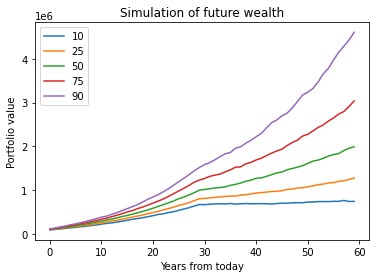

In [20]:
pd.DataFrame(list(df_simulation_result.groupby("Year")['Value'].apply(
    lambda x: np.percentile(x,[10,25,50,75,90]))),
            columns=[10,25,50,75,90]).reset_index().rename(columns={"index":"Year"}).set_index("Year").plot()
print("initial contribution:",initial_contribution,
      "yearly contribution:",yearly_contribution,
      "yearly withdraw:",yearly_withdraw)
plt.title('Simulation of future wealth')
plt.xlabel('Years from today')
plt.ylabel('Portfolio value')
plt.legend()
plt.show()

### Case 2
initial_contribution=100000

yearly_contribution=20000

yearly_withdraw=-30000

In [25]:
initial_contribution=100000
yearly_contribution=20000
yearly_withdraw=-30000

In [26]:
portfolio_return=np.concatenate((portfolio_return_during_younghood,
               portfolio_return_during_oldhood))

df_portfolio=pd.DataFrame(portfolio_return)
df_portfolio=pd.merge(df_portfolio.reset_index().rename(columns={"index":"Year"}),
         df_cashflow,
         left_on="Year",
         right_on="Year",
         how="left")

In [27]:
df_portfolio.loc[df_portfolio["Contribution"]=="initial",
                "Contribution"]=initial_contribution

df_portfolio.loc[df_portfolio["Contribution"]==1,
                "Contribution"]=yearly_contribution



df_portfolio.loc[df_portfolio["Withdraw"]==1,
                "Withdraw"]=yearly_withdraw

In [28]:
list_of_simulation_df_values=[]
for simulation in list(df_portfolio.drop(["Year","Contribution","Withdraw"],axis=1).columns):
    df_portfolio["Value"] = df_portfolio["Contribution"]*(1+df_portfolio[simulation])
    for i in range(1,len(df_portfolio)):
        df_portfolio.loc[i,"Value"] = ((df_portfolio.loc[i-1,"Value"] * (1+df_portfolio.loc[i,simulation])) +
                                       ((df_portfolio.loc[i,"Contribution"]) * (1+df_portfolio.loc[i,simulation]))+
                                       df_portfolio.loc[i,"Withdraw"])
    list_of_simulation_df_values.append(df_portfolio[["Value","Year"]])

df_simulation_result= pd.concat(list_of_simulation_df_values)

In [31]:
pd.DataFrame(list(df_simulation_result.groupby("Year")['Value'].apply(
    lambda x: np.percentile(x,[10,25,50,75,90]))),
            columns=[10,25,50,75,90]).reset_index().rename(columns={"index":"Year"}).set_index("Year")

,10,25,50,75,90
Year,,,,,
0,"94,218.888","99,433.034","104,658.090","110,328.387","115,704.310"
1,"114,222.803","121,298.930","129,855.412","139,321.093","148,283.561"
2,"135,814.994","145,540.341","157,959.823","170,769.703","183,917.065"
3,"156,796.374","170,543.062","186,477.076","205,251.898","220,688.684"
4,"179,613.268","196,504.166","215,665.597","239,001.267","261,341.513"
5,"201,216.747","222,040.280","245,356.025","273,151.143","298,661.807"
6,"226,543.448","249,293.754","278,038.820","310,657.531","341,516.988"
7,"248,827.971","278,903.483","313,502.743","351,058.622","387,765.785"
8,"276,640.382","307,072.893","349,881.715","392,041.879","435,729.791"


initial contribution: 100000 yearly contribution: 20000 yearly withdraw: -30000


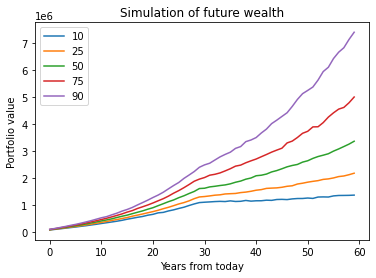

In [29]:
pd.DataFrame(list(df_simulation_result.groupby("Year")['Value'].apply(
    lambda x: np.percentile(x,[10,25,50,75,90]))),
            columns=[10,25,50,75,90]).reset_index().rename(columns={"index":"Year"}).set_index("Year").plot()

print("initial contribution:",initial_contribution,
      "yearly contribution:",yearly_contribution,
      "yearly withdraw:",yearly_withdraw)
plt.title('Simulation of future wealth')
plt.xlabel('Years from today')
plt.ylabel('Portfolio value')
plt.legend()
plt.show()